In [1]:
import pandas as pd
import numpy as np
import preprocessing as pp
import formatPredictions as fp
import datasets as datasets

#Importacion xgboost
import xgboost as xgb

#Importacion preprocesamiento
from sklearn.model_selection import train_test_split

#Importacion metricas
import metrics as m
from sklearn.metrics import roc_auc_score

#Librerias para visualizacion
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
df = datasets.getDataTrain()
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,profesional_especializado


In [3]:
df_edit = pd.DataFrame()
df_edit = df.copy()

X, y, df_new, y_encoder = pp.feature_engineering_xg_rf(df_edit)

df_new.head()

,tiene_alto_valor_adquisitivo,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_municipal,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_1_anio,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_ejercito,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [4]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = pp.GetSeedForTrainSplit(), test_size=0.2)

In [5]:
#Instancio el xgboost
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.35, learning_rate = 0.5, 
                          max_depth = 10, alpha = 5, n_estimators = 17)

xg_classifier = xgb.XGBClassifier(objective ='binary:logistic', use_label_encoder=False, colsample_bytree = 0.35, learning_rate = 0.5, 
                          max_depth = 10, alpha = 5, n_estimators = 17)

In [6]:
#Entreno
xg_reg.fit(X_train,y_train)

xg_classifier.fit(X_train,y_train)

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.35, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=17, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [7]:
#prediccion
proba_preds = xg_reg.predict(X_test)
binary_preds = xg_classifier.predict(X_test)

Accuracy: 0.8403193612774451

Precision: 0.6928152492668622

Recall: 0.915302203355569

F1 Score: 0.6450511945392492

Matriz de confusion: 
[[4528  419]
 [ 621  945]]

AUC-ROC: 



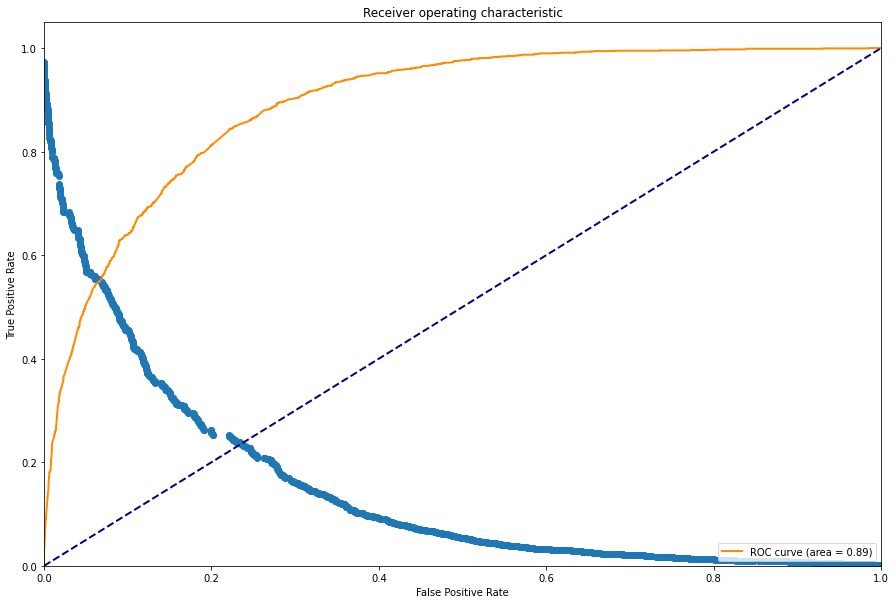

0.8922141752383697

In [8]:
# Obtener metricas
m.getMetrics(y_test, binary_preds, proba_preds)

### Prediccion agregando el rango de edad como feature

In [9]:
df_edit = pd.DataFrame()
df_edit = df.copy()

df_edit = pp.set_age_range(df_edit)

X, y, df_new, y_encoder = pp.feature_engineering_xg_rf(df_edit)

df_new.head()

,tiene_alto_valor_adquisitivo,edad_10_y_20,edad_21_y_30,edad_31_y_40,edad_41_y_50,edad_51_y_60,edad_61_y_70,edad_71_y_80,edad_81_y_90,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_municipal,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_1_anio,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_ejercito,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [10]:
data_dmatrix_ageRange = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = pp.GetSeedForTrainSplit(), test_size=0.2)

In [11]:
#Instancio el xgboost
xg_reg_ageRange = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.35, learning_rate = 0.5, 
                          max_depth = 10, alpha = 5, n_estimators = 17)

xg_classifier_ageRange = xgb.XGBClassifier(objective ='binary:logistic', use_label_encoder=False, colsample_bytree = 0.35, learning_rate = 0.5, 
                          max_depth = 10, alpha = 5, n_estimators = 17)

In [12]:
#Entreno
xg_reg_ageRange.fit(X_train,y_train)
xg_classifier_ageRange.fit(X_train,y_train)

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.35, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=17, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [13]:
#prediccion
proba_preds_ageRange = xg_reg_ageRange.predict(X_test)
binary_preds_ageRange = xg_classifier_ageRange.predict(X_test)

Accuracy: 0.8467680024566252

Precision: 0.7113095238095238

Recall: 0.9215686274509803

F1 Score: 0.6570446735395189

Matriz de confusion: 
[[4559  388]
 [ 610  956]]

AUC-ROC: 



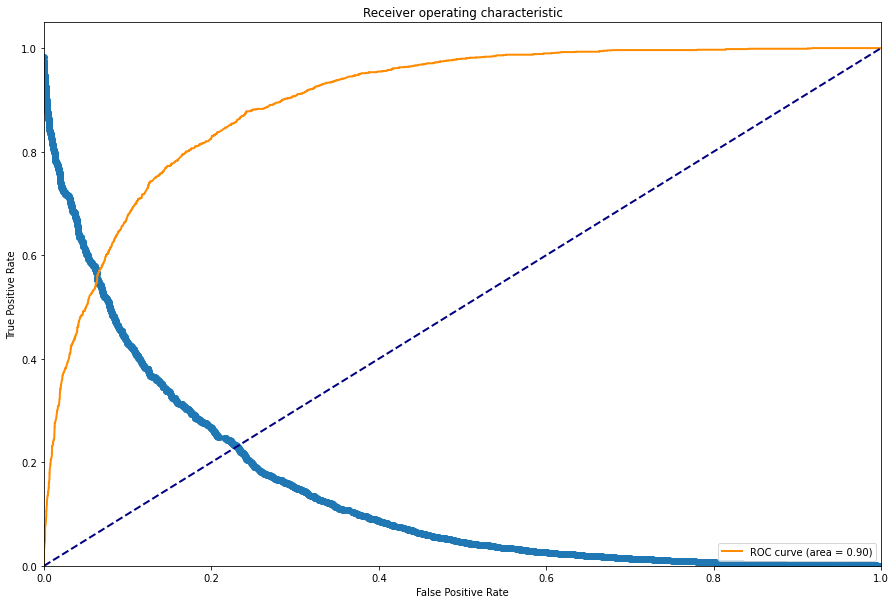

0.8986817739300959

In [14]:
# Obtener metricas
m.getMetrics(y_test, binary_preds_ageRange, proba_preds_ageRange)

### Prediccion basada en las columnas que random forest considera como las mas importantes

In [15]:
df_edit = pd.DataFrame()
df_edit = df.copy()

X, y, df_new, y_encoder = pp.feature_engineering_xg_rf(df_edit)

df_new.head()

,tiene_alto_valor_adquisitivo,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_municipal,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_1_anio,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_ejercito,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [16]:
#Instancio el xgboost
xg_reg_RF = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.35, learning_rate = 0.5, 
                          max_depth = 10, alpha = 5, n_estimators = 17)

xg_classifier_RF = xgb.XGBClassifier(objective ='binary:logistic', use_label_encoder=False, colsample_bytree = 0.35, learning_rate = 0.5, 
                          max_depth = 10, alpha = 5, n_estimators = 17)

In [17]:
#Extraigo las columnas que random forest considera las mas importantes para predecir

trainDf_with_random_forest_rows = pp.get_columns_by_index(X_train, [0, 1, 2, 21, 22, 26, 32, 33, 38])
testDf_with_random_forest_rows = pp.get_columns_by_index(X_test, [0, 1, 2, 21, 22, 26, 32, 33, 38])

In [18]:
#Entreno con los datos que me dio random forest
xg_reg_RF.fit(trainDf_with_random_forest_rows,y_train)
xg_classifier_RF.fit(trainDf_with_random_forest_rows,y_train)

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.35, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=17, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [19]:
#prediccion
proba_preds_RF = xg_reg_RF.predict(testDf_with_random_forest_rows)
binary_preds_RF = xg_classifier_RF.predict(testDf_with_random_forest_rows)

Accuracy: 0.7878089973898357

Precision: 0.5749185667752443

Recall: 0.8944815039417829

F1 Score: 0.5053686471009305

Matriz de confusion: 
[[4425  522]
 [ 860  706]]

AUC-ROC: 



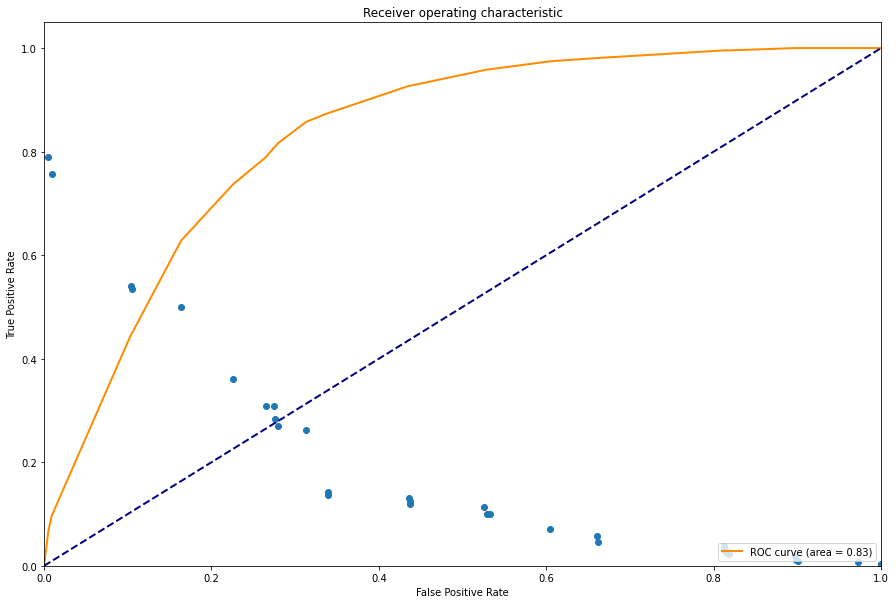

0.833070328367025

In [20]:
# Obtener metricas
m.getMetrics(y_test, binary_preds_RF, proba_preds_RF)

### Prediccion basada en las columnas que random forest considera como las mas importantes y agregando el rango de edad

In [21]:
df_edit = pd.DataFrame()
df_edit = df.copy()

df_edit = pp.set_age_range(df_edit)

X, y, df_new, y_encoder = pp.feature_engineering_xg_rf(df_edit)

df_new.head()

,tiene_alto_valor_adquisitivo,edad_10_y_20,edad_21_y_30,edad_31_y_40,edad_41_y_50,edad_51_y_60,edad_61_y_70,edad_71_y_80,edad_81_y_90,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_municipal,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_1_anio,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_ejercito,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [22]:
#Extraigo las columnas que random forest considera las mas importantes para predecir

trainDf_with_random_forest_rows = pp.get_columns_by_index(X_train, [0, 9, 10, 29, 30, 34, 40, 41, 46])
testDf_with_random_forest_rows = pp.get_columns_by_index(X_test, [0, 9, 10, 29, 30, 34, 40, 41, 46])

In [23]:
#Instancio el xgboost
xg_reg_RF_ageRange = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.35, learning_rate = 0.5, 
                          max_depth = 10, alpha = 5, n_estimators = 17)

xg_classifier_RF_ageRange = xgb.XGBClassifier(objective ='binary:logistic', use_label_encoder=False, colsample_bytree = 0.35, learning_rate = 0.5, 
                          max_depth = 10, alpha = 5, n_estimators = 17)

In [24]:
#Entreno con los datos que me dio random forest
xg_reg_RF_ageRange.fit(trainDf_with_random_forest_rows,y_train)
xg_classifier_RF_ageRange.fit(trainDf_with_random_forest_rows,y_train)

XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.35, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=17, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [25]:
#prediccion
proba_preds_RF_ageRange = xg_reg_RF_ageRange.predict(testDf_with_random_forest_rows)
binary_preds_RF_ageRange = xg_classifier_RF_ageRange.predict(testDf_with_random_forest_rows)

Accuracy: 0.8142177184093352

Precision: 0.6913978494623656

Recall: 0.9419850414392561

F1 Score: 0.515224358974359

Matriz de confusion: 
[[4660  287]
 [ 923  643]]

AUC-ROC: 



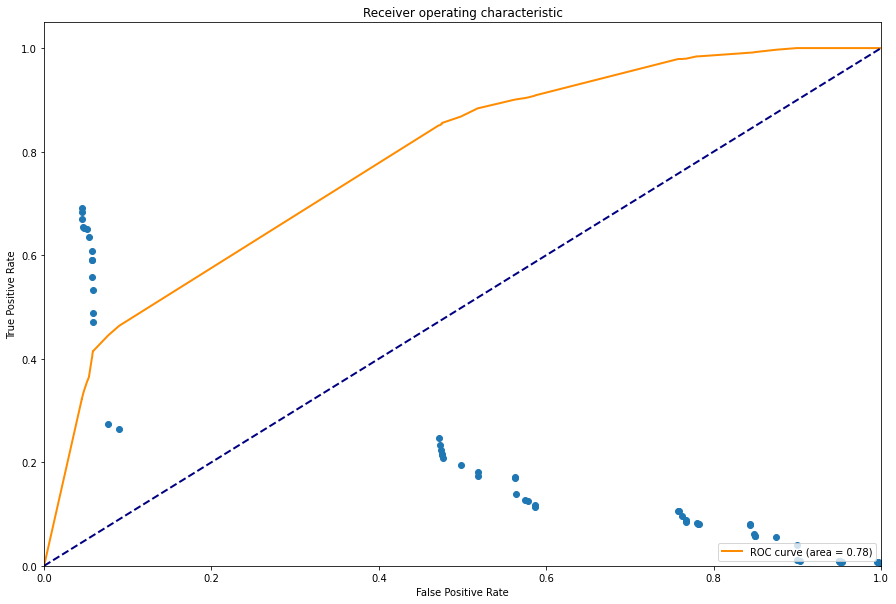

0.7808371548116291

In [26]:
# Obtener metricas
m.getMetrics(y_test, binary_preds_RF_ageRange, proba_preds_RF_ageRange)

# Analisis de features del modelo XGBoost con mejor rendimiento. (Version 2)

Importancia de cada feature

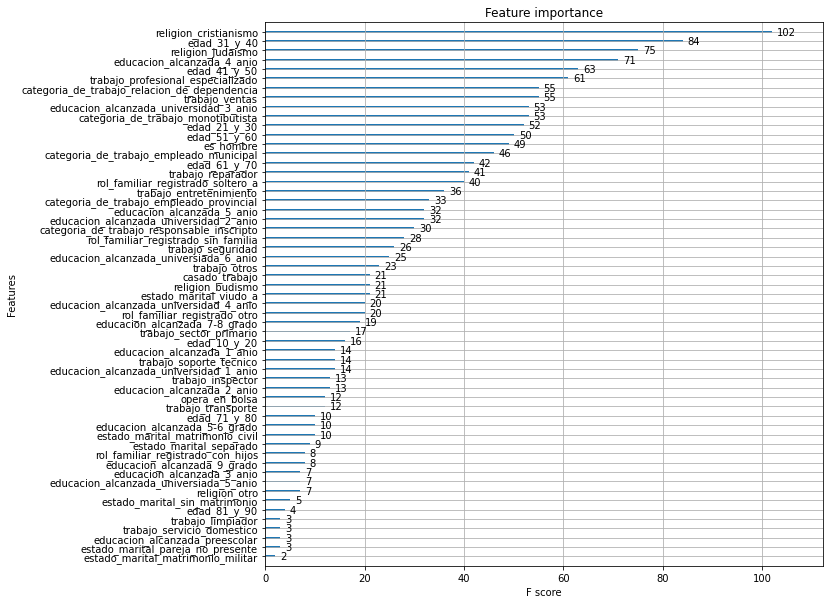

In [45]:
xgb.plot_importance(xg_reg_ageRange)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

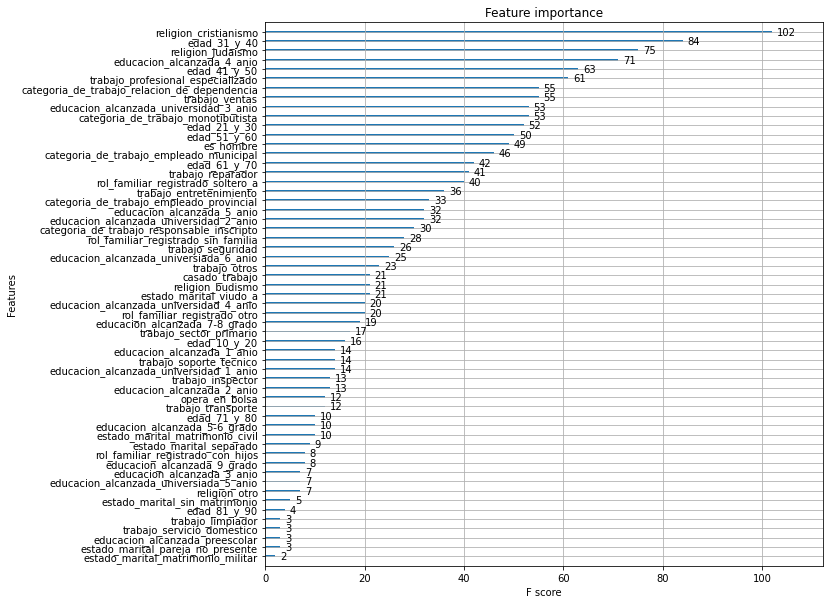

In [28]:
xgb.plot_importance(xg_classifier_ageRange)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

Cross Validation


In [29]:
params = {"objective":"binary:logistic",'colsample_bytree': 0.35,
          'learning_rate': 0.5, 'max_depth': 5, 'alpha': 10, 'silent': 1}

cv_scores = []

for n in range(10, 100, 5):
    cv_results = xgb.cv(dtrain=data_dmatrix_ageRange, params=params, nfold=5,
                    num_boost_round=n, early_stopping_rounds=10,
                    metrics="auc", as_pandas=True, seed=123);
    cv_scores.append(cv_results.iloc[-1]['test-auc-mean'])

In [30]:
cv_scores

[0.8888653999999999,
 0.8926299999999999,
 0.8945344000000001,
 0.895519,
 0.8961776,
 0.8965968,
 0.8968802,
 0.8970834,
 0.897382,
 0.8975816,
 0.8976742,
 0.897743,
 0.8978424,
 0.8979224,
 0.8979223999999999,
 0.897941,
 0.8979659999999999,
 0.8979754]

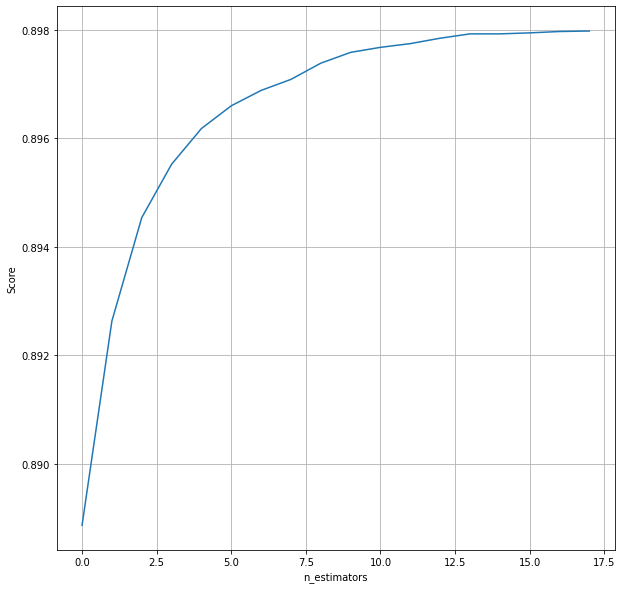

In [31]:
plt.plot([x for x in range(0, 18)], cv_scores)
plt.grid()
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.show()

Learning rate

In [32]:
cv_scores = []

for n in range(1, 11):
    eta=n*0.05
    params = {"objective":"binary:logistic",'colsample_bytree': 0.35,
          'learning_rate': eta, 'max_depth': 5, 'alpha': 10, 'silent': 1}
    print(eta)
    cv_results = xgb.cv(dtrain=data_dmatrix_ageRange, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="auc", as_pandas=True, seed=123);
    cv_scores.append(cv_results.iloc[-1]['test-auc-mean'])

0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5


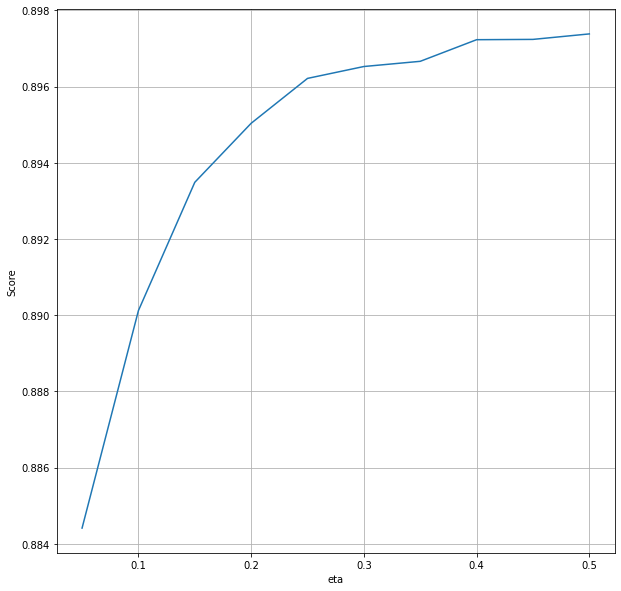

In [33]:
plt.plot([x * 0.05 for x in range(1, 11)], cv_scores)
plt.grid()
plt.xlabel('eta')
plt.ylabel('Score')
plt.show()

Max_depth

In [34]:
cv_scores = []

for n in range(1, 11):
    params = {"objective":"binary:logistic",'colsample_bytree': 0.35,
          'learning_rate': 0.1, 'max_depth': n, 'alpha': 10, 'silent': 1}
    print(n)
    cv_results = xgb.cv(dtrain=data_dmatrix_ageRange, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="auc", as_pandas=True, seed=123);
    cv_scores.append(cv_results.iloc[-1]['test-auc-mean'])

1
2
3
4
5
6
7
8
9
10


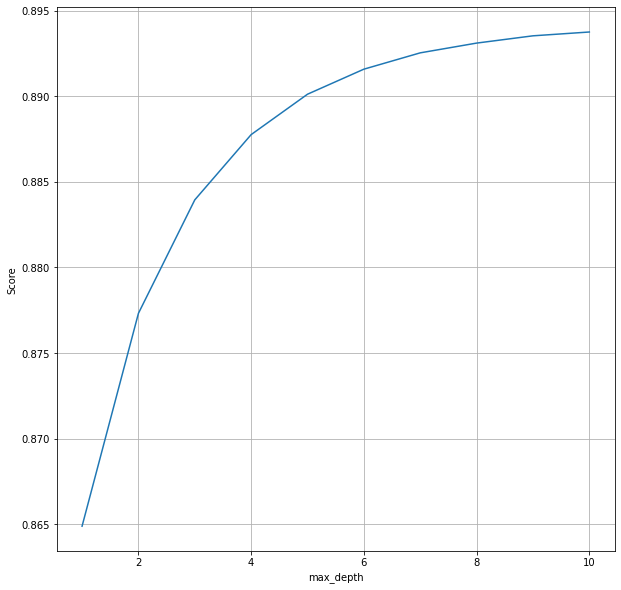

In [35]:
plt.plot([x for x in range(1, 11)], cv_scores)
plt.grid()
plt.xlabel('max_depth')
plt.ylabel('Score')
plt.show()

colsample_bytree (Valor muy alto: overfitting)

In [36]:
cv_scores = []

for n in range(1, 16):
    cst=n*0.05
    params = {"objective":"binary:logistic",'colsample_bytree': cst,
          'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10, 'silent': 1}
    print(n)
    cv_results = xgb.cv(dtrain=data_dmatrix_ageRange, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="auc", as_pandas=True, seed=123);
    cv_scores.append(cv_results.iloc[-1]['test-auc-mean'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


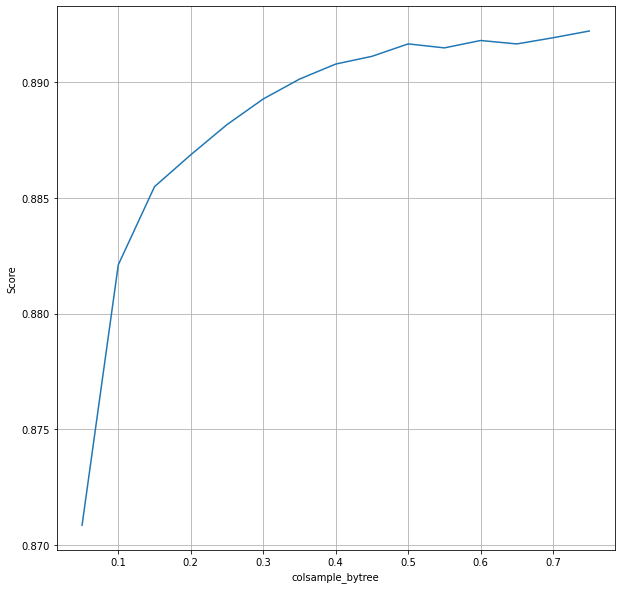

In [37]:
plt.plot([x*0.05 for x in range(1, 16)], cv_scores)
plt.grid()
plt.xlabel('colsample_bytree')
plt.ylabel('Score')
plt.show()

Alpha

In [38]:
cv_scores = []

for n in range(1, 16):
    params = {"objective":"binary:logistic",'colsample_bytree': 0.35,
          'learning_rate': 0.1, 'max_depth': 5, 'alpha': n, 'silent': 1}
    print(n)
    cv_results = xgb.cv(dtrain=data_dmatrix_ageRange, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="auc", as_pandas=True, seed=123);
    cv_scores.append(cv_results.iloc[-1]['test-auc-mean'])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


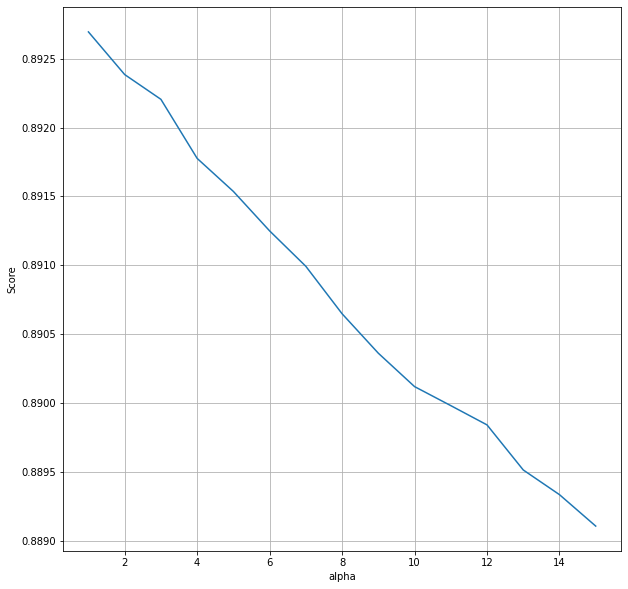

In [39]:
plt.plot([x for x in range(1, 16)], cv_scores)
plt.grid()
plt.xlabel('alpha')
plt.ylabel('Score')
plt.show()

# Prediccion sobre el archivo final

In [40]:
data_test_final = datasets.getDataHoldout()
data_test_final.drop(columns = ["representatividad_poblacional"], inplace=True)
df.rename(columns={'ganancia_perdida_declarada_bolsa_argentina': 'ganancia_perdida_declarada_bolsa_argentina'}, inplace=True)
data_test_final.head()

,id,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,trabajo
0,1,11,Palermo,relacion_de_dependencia,25,2_anio,sin_matrimonio,0,hombre,40,judaismo,con_hijos,inspector
1,2,13,Palermo,relacion_de_dependencia,38,4_anio,matrimonio_civil,0,hombre,50,cristianismo,casado,sector_primario
2,3,16,Palermo,empleado_municipal,28,universidad_2_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,seguridad
3,4,14,Palermo,relacion_de_dependencia,44,5_anio,matrimonio_civil,7688,hombre,40,judaismo,casado,inspector
4,5,14,Palermo,NaN,18,5_anio,sin_matrimonio,0,mujer,30,cristianismo,con_hijos,NaN


In [41]:
data_test_final = pp.set_age_range(data_test_final)

df_test_final = pp.feature_engineering_xg_rf(data_test_final)
df_test_final.head()

,id,edad_10_y_20,edad_21_y_30,edad_31_y_40,edad_41_y_50,edad_51_y_60,edad_61_y_70,edad_71_y_80,edad_81_y_90,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_municipal,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_1_anio,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_civil,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_budismo,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_con_hijos,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_ejercito,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
df_test_final.info

<bound method DataFrame.info of           id  edad_10_y_20  ...  trabajo_transporte  trabajo_ventas
0          1             0  ...                   0               0
1          2             0  ...                   0               0
2          3             0  ...                   0               0
3          4             0  ...                   0               0
4          5             1  ...                   0               0
...      ...           ...  ...                 ...             ...
16276  16277             0  ...                   0               0
16277  16278             0  ...                   0               0
16278  16279             0  ...                   0               0
16279  16280             0  ...                   0               0
16280  16281             0  ...                   0               0

[16281 rows x 61 columns]>

In [43]:
#prediccion
predictions_final = xg_classifier_ageRange.predict(df_test_final.iloc[:, 1:61])

In [44]:
#Exporto las predicciones
fp.exportPredictions(fp.formatPredictions(predictions_final), "predictions_final_xgboost")